<a href="https://colab.research.google.com/github/alisamir92/fruit-detection-by-pytorch-using-custom-dataset/blob/master/fruit_detection_by_pytorch_using_custom_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive


drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import torchvision
import torch
import cv2
from PIL import Image, ImageDraw
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torch.utils.data import Dataset,DataLoader
from torchvision import transforms
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

In [3]:
classes = ["background", "apple", "banana", "orange"]

In [4]:
root_dir = "/content/drive/My Drive/fruits/train/"

In [5]:
csv_file = pd.read_csv("/content/drive/My Drive/fruits/train.csv")

In [6]:
print(csv_file.head())

        filename  width  height   class  xmin  ymin  xmax  ymax  image_id
0   apple_18.jpg    610     458   apple   144   136   470   411         0
1   banana_7.jpg    615     865  banana   177    52   374   822         1
2  banana_72.jpg      0       0  banana    57   215  1711  1112         2
3  banana_72.jpg      0       0  banana   478   264  1991  1332         2
4  banana_72.jpg      0       0  banana     1   189  1594   768         2


In [7]:
print(len(csv_file[csv_file["filename"]=="banana_72.jpg"]))
print(csv_file["xmax"].max())
print(csv_file["ymax"].max())

3
3098
4515


In [8]:
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [9]:
# Create custom dataset for object detection to use for pretained Faster RCNN model:
"""
During training, the model expects both the input tensors(as list of tensors), as well as a targets (list of dictionary), containing:

- boxes (FloatTensor[N, 4]): the boxes in [x1, y1, x2, y2] format, 
  with values of x between 0 and W and values of y between 0 and H

- labels (Int64Tensor[N]): the class label for each ground-truth box

"""

class Boxes_Dataset(Dataset):
    

    def __init__(self, csv_file, root_dir, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.boxes_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.boxes_frame)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.root_dir,
                                self.boxes_frame.iloc[idx, 0])
        image = Image.open(img_name).convert("RGB")
        # image = image.resize((3500,5000))
        # unique_images = self.boxes_frame["filename"].unique()
        boxes = []
        labels_id = {'background': 0, 'apple': 1, 'banana':2, 'orange':3}
        labels = []
        for i in range(len(self.boxes_frame[self.boxes_frame["filename"]==self.boxes_frame["filename"][idx]])):
          box = self.boxes_frame[self.boxes_frame["filename"]==self.boxes_frame["filename"][idx]].iloc[i, 4:8]
          boxes.append(box)
          
          labels.append(labels_id[self.boxes_frame[self.boxes_frame["filename"]==self.boxes_frame["filename"][idx]].iloc[i, 3]])
        
        boxes = torch.as_tensor(boxes, dtype=torch.float32, device='cuda:0')
        labels = torch.as_tensor(labels, dtype=torch.int64, device='cuda:0')

        target = {}
        target['boxes'] = boxes
        target['labels'] = labels

        if self.transform:
            image = self.transform(image)
            
            

        return image, target


        

In [10]:
tansforms = transforms.Compose([
    
     transforms.ToTensor(), #ToTensor will scale image pixels from [0,255] to [0,1] values
 ])

In [11]:
dataset = Boxes_Dataset(csv_file = "/content/drive/My Drive/fruits/train.csv", root_dir= root_dir, transform=tansforms)


In [12]:
print(dataset[2][1]["boxes"].detach().cpu().numpy())
print(dataset[2][0].shape)
print(dataset[2][1])

[[5.700e+01 2.150e+02 1.711e+03 1.112e+03]
 [4.780e+02 2.640e+02 1.991e+03 1.332e+03]
 [1.000e+00 1.890e+02 1.594e+03 7.680e+02]]
torch.Size([3, 1332, 2000])
{'boxes': tensor([[5.7000e+01, 2.1500e+02, 1.7110e+03, 1.1120e+03],
        [4.7800e+02, 2.6400e+02, 1.9910e+03, 1.3320e+03],
        [1.0000e+00, 1.8900e+02, 1.5940e+03, 7.6800e+02]], device='cuda:0'), 'labels': tensor([2, 2, 2], device='cuda:0')}


In [13]:
# data_loader = torch.utils.data.DataLoader(
#  dataset, batch_size=1, shuffle=True, num_workers=0,drop_last=True)

In [14]:
valid_size = 0.2


# obtain training indices that will be used for validation
num_train = len(dataset)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

# define samplers for obtaining training and validation batches
train_sampler = torch.utils.data.sampler.SubsetRandomSampler(train_idx)
valid_sampler = torch.utils.data.sampler.SubsetRandomSampler(valid_idx)

# prepare data loaders (combine dataset and sampler)
train_loader = torch.utils.data.DataLoader(dataset, batch_size=1, sampler=train_sampler, num_workers=0, drop_last=True)
valid_loader = torch.utils.data.DataLoader(dataset, batch_size=1, sampler=valid_sampler, num_workers=0)





In [15]:
print(len(dataset))
print(len(train_loader))
print(len(valid_loader))
print(dataset[0][0].shape)

465
372
93
torch.Size([3, 458, 610])


In [16]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [17]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

    # get the number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes=4)

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


In [18]:
model.to(device)

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256)
          (relu): ReLU(inplace=True)
          (downsample)

In [19]:
# for name, p in model.named_parameters():
#     if 'roi_heads' not in name and 'rpn' not in name:
#         p.requires_grad = False

In [20]:
for name, param in model.named_parameters():
    print(name, param.requires_grad)

backbone.body.conv1.weight False
backbone.body.layer1.0.conv1.weight False
backbone.body.layer1.0.conv2.weight False
backbone.body.layer1.0.conv3.weight False
backbone.body.layer1.0.downsample.0.weight False
backbone.body.layer1.1.conv1.weight False
backbone.body.layer1.1.conv2.weight False
backbone.body.layer1.1.conv3.weight False
backbone.body.layer1.2.conv1.weight False
backbone.body.layer1.2.conv2.weight False
backbone.body.layer1.2.conv3.weight False
backbone.body.layer2.0.conv1.weight True
backbone.body.layer2.0.conv2.weight True
backbone.body.layer2.0.conv3.weight True
backbone.body.layer2.0.downsample.0.weight True
backbone.body.layer2.1.conv1.weight True
backbone.body.layer2.1.conv2.weight True
backbone.body.layer2.1.conv3.weight True
backbone.body.layer2.2.conv1.weight True
backbone.body.layer2.2.conv2.weight True
backbone.body.layer2.2.conv3.weight True
backbone.body.layer2.3.conv1.weight True
backbone.body.layer2.3.conv2.weight True
backbone.body.layer2.3.conv3.weight True


In [21]:
class Averager:
    def __init__(self):
        self.current_total = 0.0
        self.iterations = 0.0

    def send(self, value):
        self.current_total += value
        self.iterations += 1

    @property
    def value(self):
        if self.iterations == 0:
            return 0
        else:
            return 1.0 * self.current_total / self.iterations

    def reset(self):
        self.current_total = 0.0
        self.iterations = 0.0

In [22]:
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.001, momentum=0.9, weight_decay=0.0005)

In [23]:

epoch_n = 100
train_loss_min = np.Inf

valid_loss_min = np.Inf

train_loss_hist = Averager()

valid_loss_hist = Averager()

for epoch in range(1, epoch_n):  # loop over the dataset multiple times
    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0

    train_loss_hist.reset()

    valid_loss_hist.reset()

    for images, targets in train_loader:
        # get the inputs
        images = images.to(device)
        images = list(image.squeeze(dim=0) for image in images)
        targets = [{k: v.squeeze(dim=0) for k, v in targets.items()}]
        
        # forward + backward + optimize
        optimizer.zero_grad() # zero the parameter gradients

        train_loss_dict = model(images, targets)
        
        train_losses = sum(loss for loss in train_loss_dict.values())

        train_loss_value = train_losses.item()

        train_loss_hist.send(train_loss_value)
        
        train_losses.backward()

        optimizer.step()

        train_loss = train_loss_hist.value

    ######################    
    # validate the model #
    ######################
   
    for images, targets in valid_loader:
        # get the inputs
        images = images.to(device)
        images = list(image.squeeze(dim=0) for image in images)
        targets = [{k: v.squeeze(dim=0) for k, v in targets.items()}]
        
        # forward + backward + optimize
        optimizer.zero_grad() # zero the parameter gradients

        valid_loss_dict = model(images, targets)
        
        valid_losses = sum(loss for loss in valid_loss_dict.values())

        valid_loss_value = valid_losses.item()

        valid_loss_hist.send(valid_loss_value)
        
        valid_losses.backward()

        optimizer.step()
        
        valid_loss = valid_loss_hist.value

    train_loss = train_loss
    valid_loss = valid_loss

    # print training/validation statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
          epoch, train_loss, valid_loss))
      
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model, '/content/drive/My Drive/fruits/model.pt') #save the new trained model
        valid_loss_min = valid_loss
        train_loss_min = train_loss
    

print('Finished Training')

/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Epoch: 1 	Training Loss: 0.395934 	Validation Loss: 0.222937
Validation loss decreased (inf --> 0.222937).  Saving model ...
Epoch: 2 	Training Loss: 0.198870 	Validation Loss: 0.153664
Validation loss decreased (0.222937 --> 0.153664).  Saving model ...
Epoch: 3 	Training Loss: 0.151928 	Validation Loss: 0.129397
Validation loss decreased (0.153664 --> 0.129397).  Saving model ...
Epoch: 4 	Training Loss: 0.125157 	Validation Loss: 0.100605
Validation loss decreased (0.129397 --> 0.100605).  Saving model ...
Epoch: 5 	Training Loss: 0.108933 	Validation Loss: 0.090892
Validation loss decreased (0.100605 --> 0.090892).  Saving model ...
Epoch: 6 	Training Loss: 0.097740 	Validation Loss: 0.082622
Validation loss decreased (0.090892 --> 0.082622).  Saving model ...
Epoch: 7 	Training Loss: 0.090446 	Validation Loss: 0.085078
Epoch: 8 	Training Loss: 0.081088 	Validation Loss: 0.077549
Validation loss decreased (0.082622 --> 0.077549).  Saving model ...
Epoch: 9 	Training Loss: 0.078575 

In [24]:

trained_model = torch.load("/content/drive/My Drive/fruits/model.pt", map_location=torch.device('cuda')) #load the new trained model

In [25]:
def predict(image, model, device, detection_threshold):
    """
    During inference, the model requires only the input tensors, and returns the post-processed predictions as a List[Dict[Tensor]], 
            one for each input image. The fields of the Dict are as follows:

      -boxes (FloatTensor[N, 4]): the predicted boxes in [x1, y1, x2, y2] format,
        with values of x between 0 and W and values of y between 0 and H

      -labels (Int64Tensor[N]): the predicted labels for each image

      -scores (Tensor[N]): the scores or each prediction


    """
    # transform the image to tensor
    transform = transforms.Compose([
    
     transforms.ToTensor(), # ToTensor will scale image pixels from [0,255] to [0,1] values
 ])
    image = transform(image).to(device)
    image = image.unsqueeze(0) # add a batch dimension
    model.eval()
    outputs = model(image) # get the predictions on the image
    
    # get all the predicited class names
    pred_classes = [classes[i] for i in outputs[0]['labels'].cpu().numpy()]
    # get score for all the predicted objects
    pred_scores = outputs[0]['scores'].detach().cpu().numpy()
    # get all the predicted bounding boxes
    pred_bboxes = outputs[0]['boxes'].detach().cpu().numpy()
    # get boxes above the threshold score
    boxes = pred_bboxes[pred_scores >= detection_threshold]
    return boxes, pred_classes
    

In [26]:
def draw_boxes(boxes, pred_classes, image):
    # draw boxes for predicted images
    
    image = np.array(image)
    
    for i, box in enumerate(boxes):
        
        cv2.rectangle(
            image,
            (int(box[0]), int(box[1])),
            (int(box[2]), int(box[3])),
            (250,0,0), 2
        )
        cv2.putText(image, pred_classes[i], (int(box[0]), int(box[1])),
                    cv2.FONT_HERSHEY_SIMPLEX, 2, (250,0,0), 5, 
                    lineType=cv2.LINE_AA)
    return image

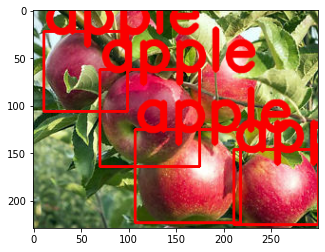

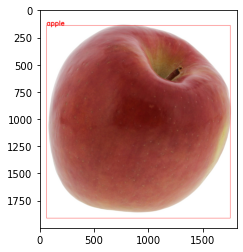

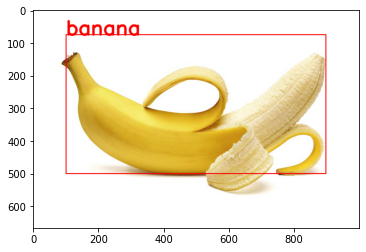

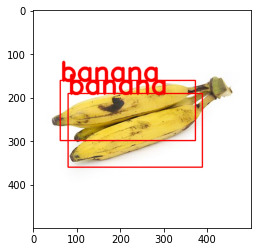

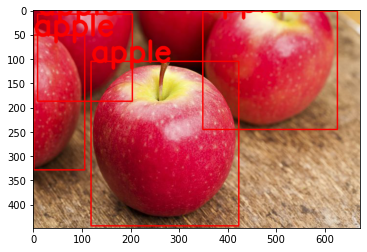

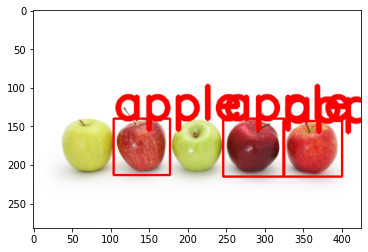

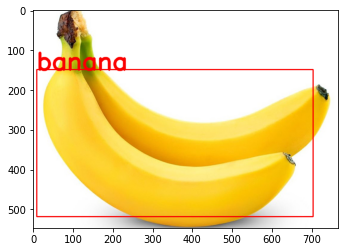

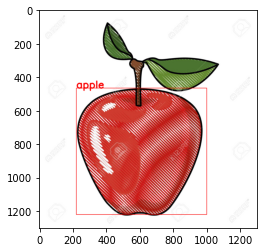

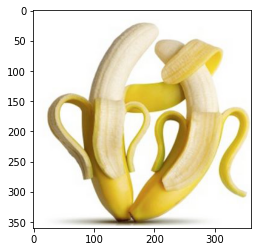

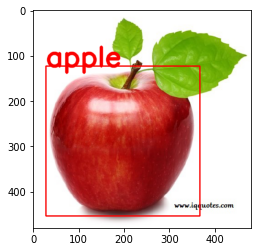

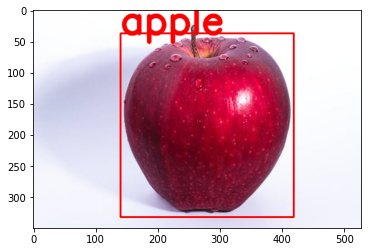

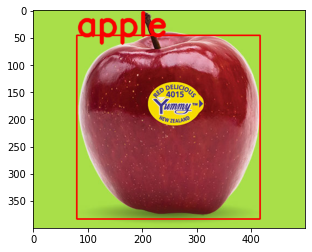

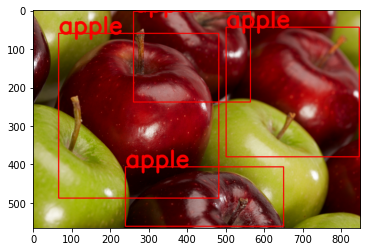

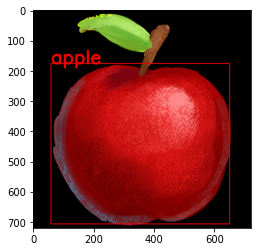

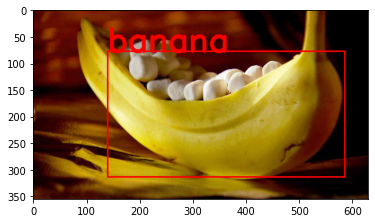

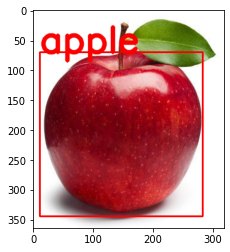

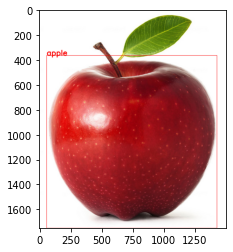

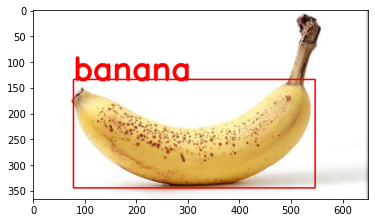

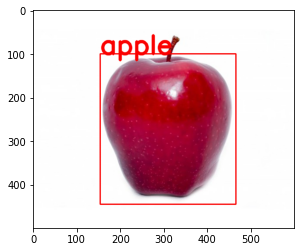

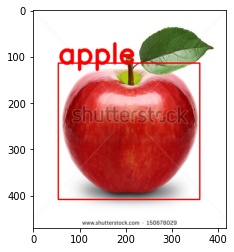

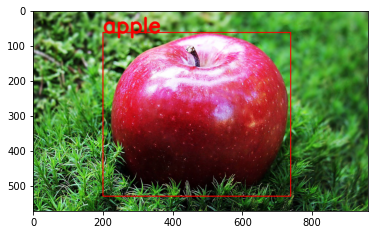

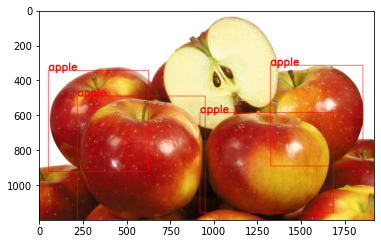

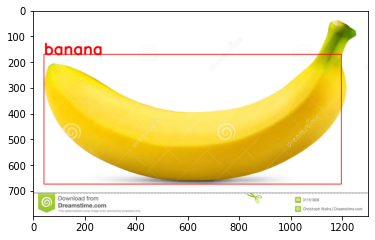

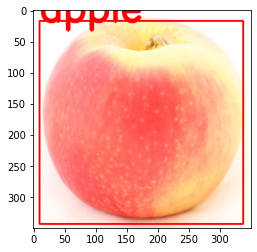

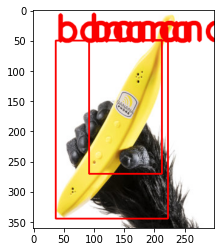

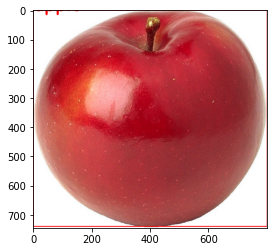

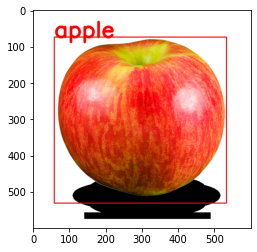

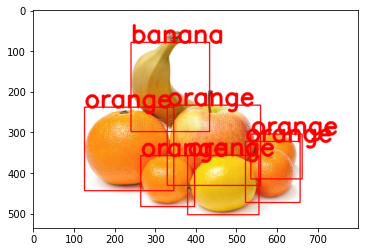

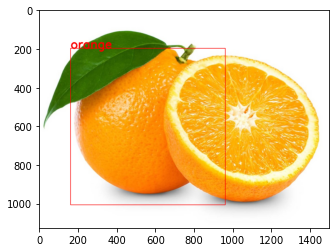

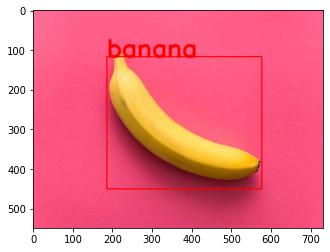

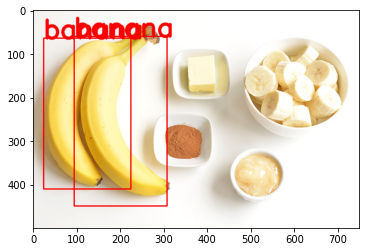

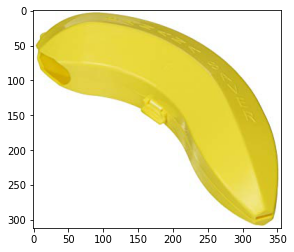

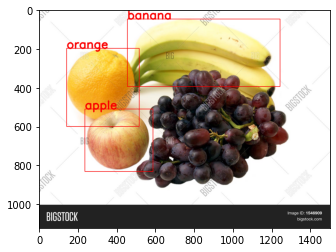

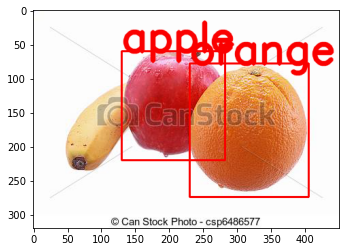

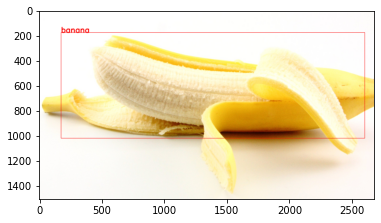

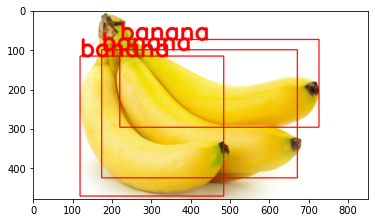

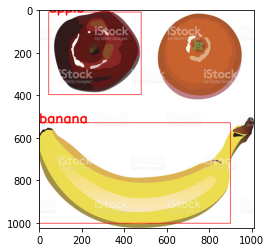

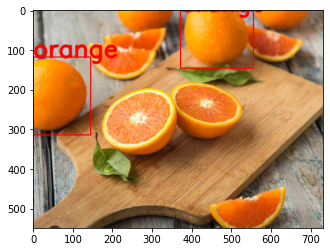

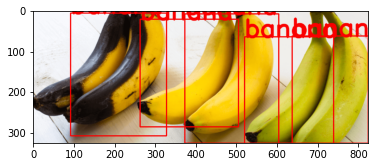

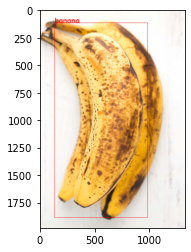

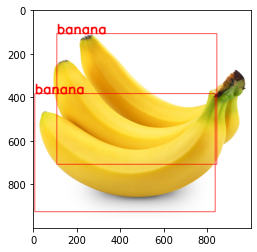

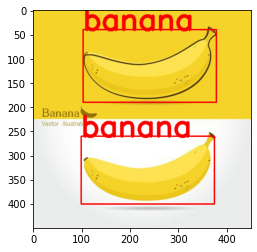

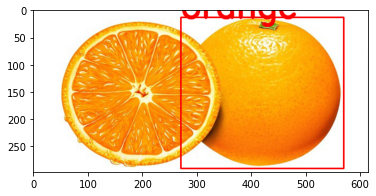

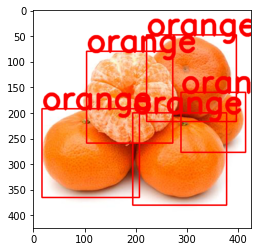

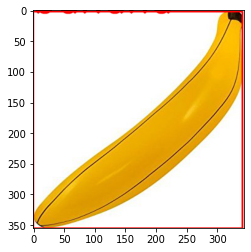

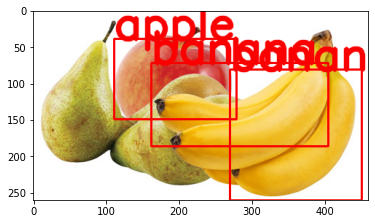

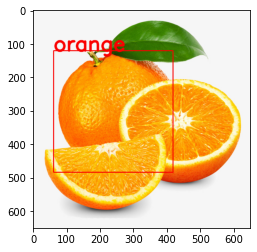

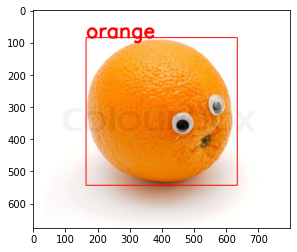

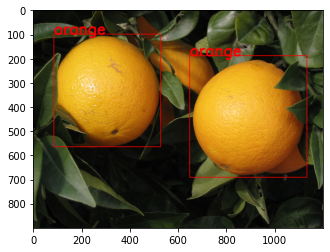

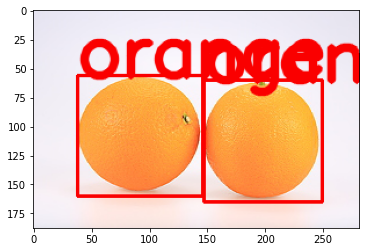

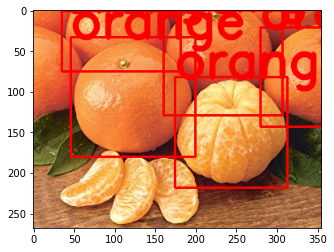

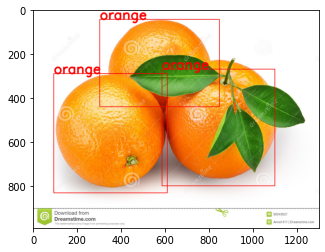

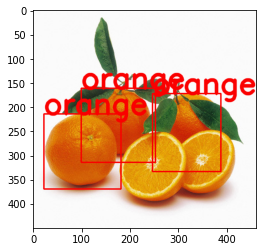

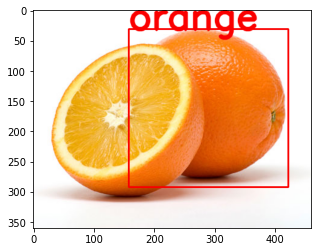

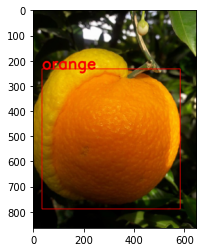

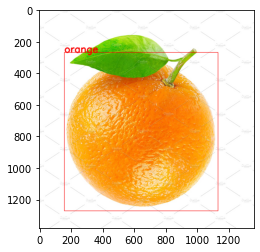

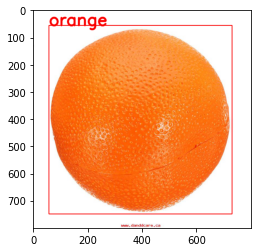

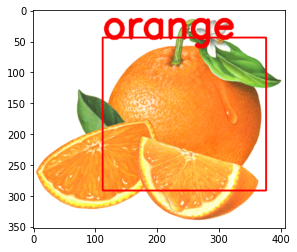

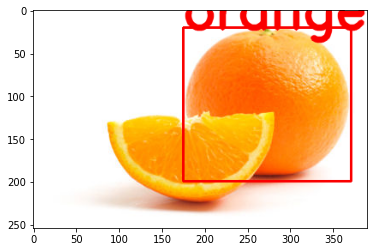

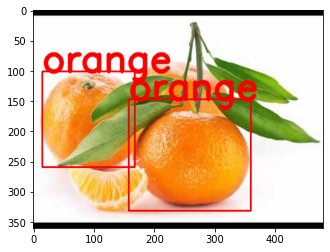

In [27]:
# the prediction

test_path = "/content/drive/My Drive/fruits/test/"
for img in os.listdir(test_path):
  image = Image.open(os.path.join(test_path, img)).convert("RGB")
  
  boxes, pred_classes = predict(image, trained_model, device, 0.8)
  # print(pred_classes)
  # print(boxes)
  plt.imshow(draw_boxes(boxes,pred_classes, image))
  plt.show()